# Supersymmetry with [**XGBoost**](https://xgboost.readthedocs.io/en/latest/index.html#) and [**Ax**](https://ax.dev/) (Bayesian Optimization) 

We will be optimizing XGBoost hyperparameters in the [supersymmetry (SUSY)](https://archive.ics.uci.edu/ml/datasets/SUSY#) dataset, first introduced by [1402.4735](https://arxiv.org/pdf/1402.4735.pdf), using [**Ax**](https://ax.dev/), the new open-source AI framework launched by Facebook in 2019.

`Ax` is used here for Bayesian hyperparameter optimization.
[**Bayesian optimization**](https://en.wikipedia.org/wiki/Bayesian_optimization) in `Ax` is powered by `BoTorch`, a modern library for Bayesian optimization research built on `PyTorch`.

This is a **binary classification** task where we are trying to distinguish between a process where new supersymmetric particles are produced (**signal process**), leading to a final state in which some particles  are  detectable  and  others  are  invisible  to  the experimental apparatus, and a **background process** with the  same  detectable  particles  but  fewer  invisible  particles  and  distinct  kinematic  features.


## 1. Overview

In particle physics, [supersymmetry (SUSY)](https://en.wikipedia.org/wiki/Supersymmetry) is a conjectured relationship between two basic classes of elementary particles: bosons, which have an integer-valued spin, and fermions, which have a half-integer spin.

### 1.1 Data

The supersymmetry data set consists of **5,000,000 Monte-Carlo samples** of supersymmetric and non-supersymmetric collisions with **18 features**. 

The last **500,000** simulated examples are used as a test set and are generated from the same Monte Carlo procedures as the training sets. 

The data set is nearly balanced, with 46% positive examples.

The dataset containing the five million simulated collision events is available for download at [archive.ics.uci.edu/ml/datasets/SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY#).

### 1.2 Problem Definition

*The vast majority of particle collisions do not produce exotic particles. For example, though the [Large Hadron Collider](https://home.cern/science/accelerators/large-hadron-collider) produces approximately $10^{11}$ collisions per hour, approximately 300 of these collisions result in a Higgs boson, on average. Therefore, good data analysis depends on distinguishing collisions which produce particles of interest (**signal**) from those producing other particles (**background**).* [1402.4735](https://arxiv.org/pdf/1402.4735.pdf)

In our supersymmetry classification problem, 

> *The  **signal  process**  is  the  production  of  electrically-charged supersymmetric particles ($\chi^\pm$), which decay to $W$ bosons  and  an  electrically-neutral  supersymmetric particle $\chi^0$, which is invisible to the detector. The $W$ bosons decay to charged leptons $\ell$ and invisible neutrinos $\nu$.*

<img src="diagrams/signal.png" title="Signal Process" />

while 

> *The **background process** is the production of pairs of $W$ bosons, which decay to charged leptons $\ell$ and invisible neutrinos $\nu$.*

<img src="diagrams/background.png" title="Background Process" />

In a statement,
> Given the 18 features, can we predict whether or not a process is supersymmetric?

### 1.3 Features

The first column is the **class label** (1 for *signal*, 0 for *background*), followed by **18 features**:

1. `lepton-1-pT`

2. `lepton-1-eta`

3. `lepton-1 phi`

4. `lepton-2-pT`

5. `lepton-2-eta`

6. `lepton-2-phi`

7. `missing-energy-magnitude`

8. `missing-energy-phi`

9. `MET_rel`

10. `axial-MET`

11. `M_R`

12. `M_TR_2`

13. `R`

14. `MT2`

15. `S_R`

16. `M_Delta_R`

17. `dPhi_r_b`

18. `cos(theta_r1)`. 

The first 8 features are kinematic properties measured by the particle detectors in the accelerator (**low-level features**).

The last ten features are functions of the first 8 features; these are **high-level features** derived by physicists to help discriminate between the two classes.

For detailed information about each feature see the [original paper](https://arxiv.org/pdf/1402.4735.pdf).

## 2. Preparing the Tools

Import libraries. In addition to the usual Python machine learning stack and `XGBoost`, we use `Ax`.

`Ax` is a platform for optimizing any kind of experiment, including machine learning experiments.
`Ax` uses `PyTorch` under the hood and can optimize

* discrete configurations (e.g., variants of an A/B test) using multi-armed bandit optimization,


* continuous (e.g., integer or floating point)-valued configurations using Bayesian optimization.

`Ax` developers recommend installing `Ax` via `pip` (even if using `Conda` environment):

`conda install pytorch torchvision -c pytorch`

`pip3 install ax-platform`


In [1]:
# Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# scikit-learn
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score, roc_curve, auc

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

# Ax
import torch
from ax.service.managed_loop import optimize

import pickle

# Dataframe display precision from 6 to 4 digits to enhance readability.
pd.options.display.precision = 4

## 3. Load Data

In [2]:
df = pd.read_csv('data/SUSY.csv')
df

,0.000000000000000000e+00,9.728614687919616699e-01,6.538545489311218262e-01,1.176224589347839355e+00,1.157156467437744141e+00,-1.739873170852661133e+00,-8.743090629577636719e-01,5.677649974822998047e-01,-1.750000417232513428e-01,8.100607395172119141e-01,-2.525521218776702881e-01,1.921887040138244629e+00,8.896374106407165527e-01,4.107718467712402344e-01,1.145620822906494141e+00,1.932632088661193848e+00,9.944640994071960449e-01,1.367815494537353516e+00,4.071449860930442810e-02
0,1.0,1.6680,0.0642,-1.2252,0.5061,-0.3389,1.6725,3.4755,-1.2191,0.0130,3.7752,1.0460,0.5681,0.4819,0.0000,0.4484,0.2054,1.3219,0.3776
1,1.0,0.4448,-0.1343,-0.7100,0.4517,-1.6139,-0.7687,1.2199,0.5040,1.8312,-0.4314,0.5263,0.9415,1.5875,2.0243,0.6035,1.5624,1.1355,0.1809
2,1.0,0.3813,-0.9761,0.6932,0.4490,0.8918,-0.6773,2.0331,1.5330,3.0463,-1.0053,0.5694,1.0152,1.5822,1.5519,0.7612,1.7155,1.4923,0.0907
3,1.0,1.3100,-0.6901,-0.6763,1.5893,-0.6933,0.6229,1.0876,-0.3817,0.5892,1.3655,1.1793,0.9682,0.7286,0.0000,1.0832,0.0434,1.1549,0.0949
4,0.0,0.4564,1.0994,1.5125,0.7518,0.6390,-0.7422,0.3226,1.3211,0.1695,0.3599,0.4893,0.4162,0.7548,0.3038,0.4611,0.3455,0.7332,0.1860
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999994,1.0,0.8533,-0.9618,-1.4873,0.6782,0.4936,1.6480,1.8439,0.2770,1.0251,-1.4865,0.8929,1.6844,1.6741,3.3663,1.0467,2.6466,1.3892,0.3646
4999995,0.0,0.9516,0.1394,1.4369,0.8804,-0.3519,-0.7409,0.2909,-0.7324,0.0014,0.2577,0.8029,0.5453,0.6027,0.0030,0.7490,0.4012,0.4435,0.2400
4999996,0.0,0.8404,1.4192,-1.2188,1.1956,1.6956,0.6638,0.4909,-0.5092,0.7043,0.0457,0.8250,0.7235,0.7782,0.7529,0.8390,0.6140,1.2106,0.0267
4999997,1.0,1.7842,-0.8336,-0.5601,0.9533,-0.6890,-1.4282,2.6607,-0.8613,2.1169,2.9062,1.2323,0.9524,0.6858,0.0000,0.7819,0.6760,1.1978,0.0937


The size of our dataset is 4,999,999 x 19.

### 3.1 Rename columns

In [3]:
# class label (SUSY) and complete set of 18 features
features = ['SUSY',
            'lepton-1-pT', 
            'lepton-1-eta', 
            'lepton-1-phi', 
            'lepton-2-pT', 
            'lepton-2-eta', 
            'lepton-2-phi', 
            'missing-energy-magnitude', 
            'missing-energy-phi', 
            'MET_rel',
            'axial-MET', 
            'M_R', 
            'M_TR_2', 
            'R', 
            'MT2', 
            'S_R',
            'M_Delta_R',
            'dPhi_r_b', 
            'cos(theta_r1)']

# 8 low-level features
low_features = ['lepton-1-pT', 
                'lepton-1-eta', 
                'lepton-1-phi', 
                'lepton-2-pT', 
                'lepton-2-eta', 
                'lepton-2-phi', 
                'missing-energy-magnitude', 
                'missing-energy-phi']

# 10 high-level features
high_features = ['MET_rel',
                 'axial-MET', 
                 'M_R', 
                 'M_TR_2', 
                 'R', 
                 'MT2', 
                 'S_R',
                 'M_Delta_R',
                 'dPhi_r_b', 
                 'cos(theta_r1)']

In [4]:
df.columns=features
df.head()

,SUSY,lepton-1-pT,lepton-1-eta,lepton-1-phi,lepton-2-pT,lepton-2-eta,lepton-2-phi,missing-energy-magnitude,missing-energy-phi,MET_rel,axial-MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,1.0,1.6680,0.0642,-1.2252,0.5061,-0.3389,1.6725,3.4755,-1.2191,0.0130,3.7752,1.0460,0.5681,0.4819,0.0000,0.4484,0.2054,1.3219,0.3776
1,1.0,0.4448,-0.1343,-0.7100,0.4517,-1.6139,-0.7687,1.2199,0.5040,1.8312,-0.4314,0.5263,0.9415,1.5875,2.0243,0.6035,1.5624,1.1355,0.1809
2,1.0,0.3813,-0.9761,0.6932,0.4490,0.8918,-0.6773,2.0331,1.5330,3.0463,-1.0053,0.5694,1.0152,1.5822,1.5519,0.7612,1.7155,1.4923,0.0907
3,1.0,1.3100,-0.6901,-0.6763,1.5893,-0.6933,0.6229,1.0876,-0.3817,0.5892,1.3655,1.1793,0.9682,0.7286,0.0000,1.0832,0.0434,1.1549,0.0949
4,0.0,0.4564,1.0994,1.5125,0.7518,0.6390,-0.7422,0.3226,1.3211,0.1695,0.3599,0.4893,0.4162,0.7548,0.3038,0.4611,0.3455,0.7332,0.1860


The target variable is the first column (*SUSY*), with possible values 1.0 (SUSY) and 0.0 (not SUSY).

## 4. Data Exploration (exploratory data analysis or ETA) &#128200;

In [5]:
# Are there any missing values?
df.isna().sum()

SUSY                        0
lepton-1-pT                 0
lepton-1-eta                0
lepton-1-phi                0
lepton-2-pT                 0
lepton-2-eta                0
lepton-2-phi                0
missing-energy-magnitude    0
missing-energy-phi          0
MET_rel                     0
axial-MET                   0
M_R                         0
M_TR_2                      0
R                           0
MT2                         0
S_R                         0
M_Delta_R                   0
dPhi_r_b                    0
cos(theta_r1)               0
dtype: int64

In [6]:
# The data set is nearly balanced, with 46% positive examples
df['SUSY'].value_counts(1)

0.0    0.5424
1.0    0.4576
Name: SUSY, dtype: float64

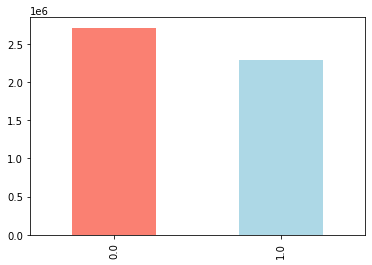

In [7]:
# Plotting
df['SUSY'].value_counts().plot(kind='bar', color=['salmon', 'lightblue']);

### 4.1 Distributions  of  features

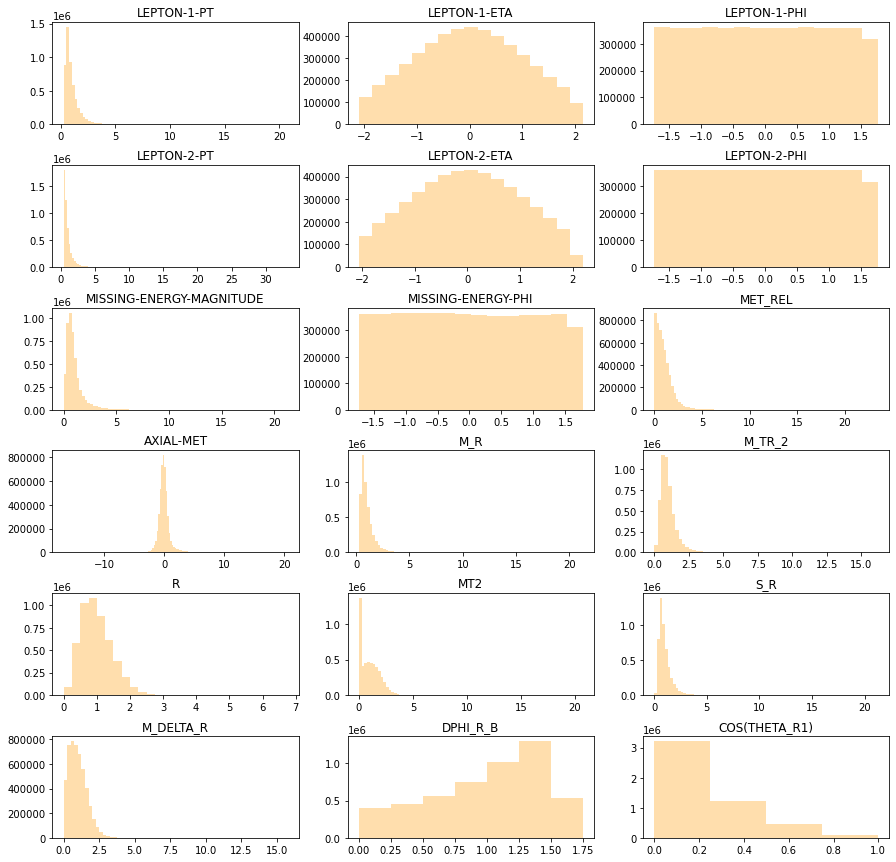

In [8]:
features = df.drop('SUSY', axis=1)

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace = 0.4, wspace=.2)

# alpha is used for transparency
for ax, name in zip(axes.flatten(), features.columns):
    bins=np.arange(min(features[name]), max(features[name]) + 0.25, 0.25)
    ax.hist(features[name], color='navajowhite', bins=bins)
    ax.set(title=name[:].upper())

###  4.2 Distributions  of  features for both signal and background processes

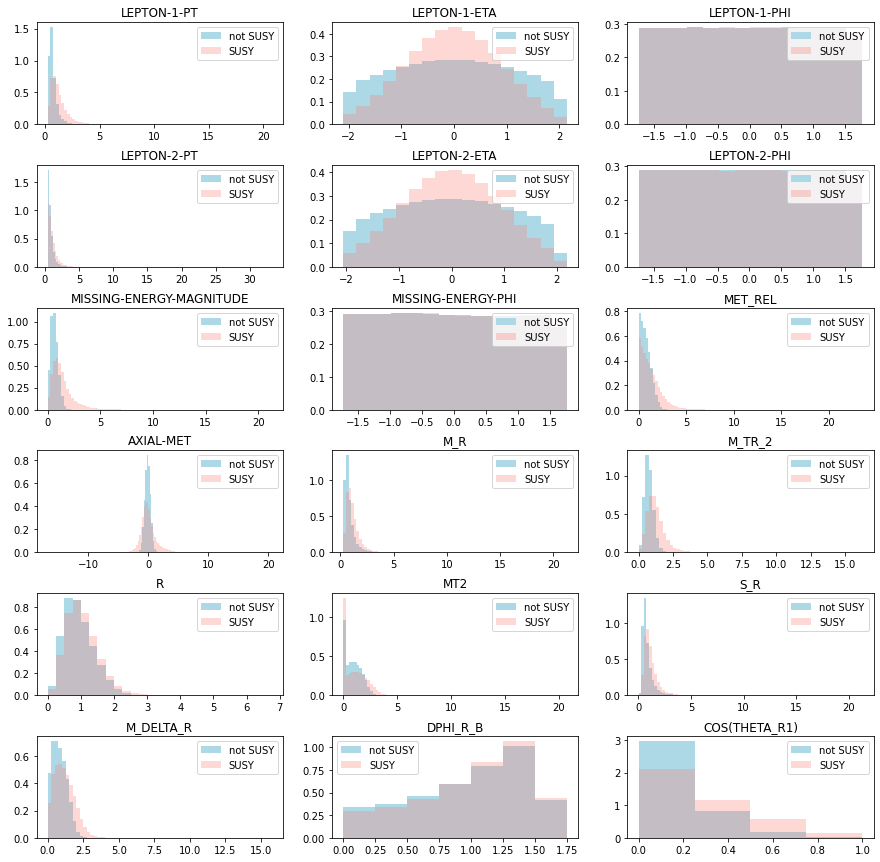

In [9]:
# Plotting each feature as a function of label (0: the process is not supersymmetric, 1: the process 
# is supersymmetric)

labels = df['SUSY']

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace = .4, wspace=.2)

# Density=True is used for normalization
for ax, name in zip(axes.flatten(), features.columns):
    bins = bins=np.arange(min(features[name]), max(features[name]) + 0.25, 0.25)
    ax.hist(features[name][labels==0.0], color='lightblue', density=True, label='not SUSY', bins=bins)
    ax.hist(features[name][labels==1.0], color='salmon', density=True, alpha=0.3, label='SUSY', bins=bins)
    ax.set(title=name[:].upper())   
    ax.legend()

## 5. Splitting Data into Train, Validation and Test Sets

Prepare the train, validation, and test sets. We use a separate **validation set** in the optimization to **avoid overfitting hyperparameters** to the test set. 

In [10]:
# The last 500,000 simulated examples are used as a test set
df_test_complete = df.tail(500000)
df_test_complete.head()

,SUSY,lepton-1-pT,lepton-1-eta,lepton-1-phi,lepton-2-pT,lepton-2-eta,lepton-2-phi,missing-energy-magnitude,missing-energy-phi,MET_rel,axial-MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
4499999,0.0,2.0883,1.5562,-1.1598,2.5648,0.6408,1.3414,1.0966,0.7976,1.3819,-0.2003,2.1621,1.8092,0.7425,2.5941,1.9589,2.3997,0.4656,0.1993
4500000,0.0,0.4832,0.2937,-0.2725,0.4741,0.0628,-0.8677,1.1424,0.6964,1.7148,-0.2885,0.4036,0.8980,1.9744,1.8886,0.4740,1.4207,1.1072,0.0439
4500001,0.0,0.6531,1.3966,1.3253,0.6561,-1.0344,1.7017,1.0340,-0.2279,1.5522,-0.7204,1.2043,1.1521,0.8489,2.4227,1.2280,1.8563,1.3939,0.0595
4500002,1.0,2.2121,0.0832,1.6624,2.7759,0.4373,-0.1141,0.3587,-1.0558,0.1414,0.4699,2.0660,0.9059,0.3891,0.0000,2.0561,0.2343,0.5948,0.0610
4500003,0.0,0.5782,-1.3031,-1.4961,0.6085,-1.4930,0.3799,1.0056,-0.5980,1.5095,-0.0984,0.4956,0.8140,1.4574,0.8428,0.5658,0.9738,1.3705,0.1274


In [11]:
# Training dataset
df_train_complete = df[:4499999]
df_train_complete.tail()

,SUSY,lepton-1-pT,lepton-1-eta,lepton-1-phi,lepton-2-pT,lepton-2-eta,lepton-2-phi,missing-energy-magnitude,missing-energy-phi,MET_rel,axial-MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
4499994,0.0,1.0634,-1.4386,-1.3378,1.2378,-1.8394,-0.1184,0.7362,0.8615,1.0935,-0.4214,0.9723,1.1130,1.0158,1.8496,0.9711,1.3818,0.5090,0.1712
4499995,1.0,1.0721,-0.9685,-1.5633,1.1506,0.7297,0.2650,3.1314,0.0008,2.2140,-2.8275,1.4162,2.0741,1.2997,1.0367,1.6819,2.4633,1.5862,0.3676
4499996,1.0,3.6752,-0.8303,-1.4652,3.9652,0.2008,-0.0645,2.7487,-0.4286,2.5673,1.2977,3.7436,3.0230,0.7166,0.0000,3.6652,1.5770,0.9657,0.1783
4499997,0.0,0.5255,-0.4123,-1.4043,0.7086,-1.1591,-0.6233,0.7978,0.5224,1.1975,-0.4546,0.5476,0.9107,1.4758,1.8162,0.5771,1.3604,1.1259,0.2199
4499998,1.0,1.7556,-0.0781,-1.2031,0.9022,1.0133,0.2020,0.5793,0.7740,0.6897,-0.2539,1.3987,1.1508,0.7301,1.0750,1.3180,1.1278,0.1253,0.3055


We are going to use only a small subset of all the data (20,000 out of a total of 5,000,000 datapoints).

In [12]:
np.random.seed(22)

# We will only work with a subset of data for demonstration purposes
df_train = shuffle(df_train_complete).head(20000) # training: 20,000 Monte-Carlo samples 
df_val = shuffle(df_train_complete).tail(5000) # validation: 5,000 Monte-Carlo samples 
df_test = shuffle(df_test_complete).head(5000) # testing: 5,000 Monte-Carlo samples

X_train = df_train.drop('SUSY', axis=1)
y_train = df_train['SUSY']
X_val = df_val.drop('SUSY', axis=1)
y_val = df_val['SUSY']
X_test = df_test.drop('SUSY', axis=1)
y_test = df_test['SUSY']

In [13]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((20000, 18), (20000,), (5000, 18), (5000,), (5000, 18), (5000,))

In [14]:
# Check our train, validation and test datasets are as balanced as the complete dataset
y_train.value_counts(1), y_val.value_counts(1), y_test.value_counts(1)

(0.0    0.5483
 1.0    0.4517
 Name: SUSY, dtype: float64,
 0.0    0.545
 1.0    0.455
 Name: SUSY, dtype: float64,
 0.0    0.5492
 1.0    0.4508
 Name: SUSY, dtype: float64)

Prepare the train, validation, and test sets in the [xgboost.DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix) format to make `XGBoost` more efficient.

In [15]:
DM_train = xgb.DMatrix(X_train, label=y_train)
DM_val = xgb.DMatrix(X_val, label=y_val)
DM_test = xgb.DMatrix(X_test, label=y_test)

## 6. XGBoost Model with Untuned Hyperparameters

In [16]:
np.random.seed(0)

# train untuned model
bst_un = xgb.train({'objective':'binary:logistic'}, DM_train)
# Calculate predictions for the test set using the untuned model
preds_un = bst_un.predict(DM_test)

In [17]:
# AUC with auc
fpr_un, tpr_un, _ = roc_curve(y_test, preds_un)
roc_auc_un = auc(fpr_un, tpr_un)
roc_auc_un

0.8639821187032717

This result shows that with the default parameters one can already achieve a ROC AUC of 0.864 using all the features (kinematic and hand crafted).

We can summarize this result by plotting the ROC curve. ROC curves typically feature *true positive rate* (*tpr*) on the Y axis, and *false positive rate* (*fpr*) on the X axis. Here, we will use the modified version used in **high-energy physics** plotting the *true negative rate* (*tnr*, with *tnr* = $1-$*tpr*) (**background rejection**) against the *tpr* (**signal efficiency**).

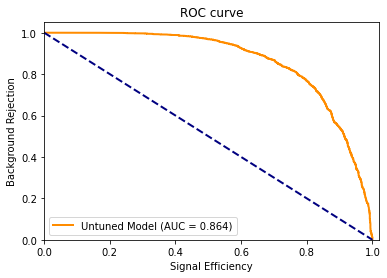

In [18]:
# Plot ROC curve
plt.plot(tpr_un, 1-fpr_un, color='darkorange',lw=2, label='Untuned Model (AUC = %0.3f)' % roc_auc_un)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.05])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('ROC curve')
plt.legend(loc="lower left");

## 7. Bayesian Optimization with Ax

Create the `XGBTrainer` class for convenience. We will use ROC AUC as metric.

Key concepts here are [xgboost.train](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.train) and [early stopping](https://xgboost.readthedocs.io/en/latest/python/python_intro.html#early-stopping).

In [19]:
class XGBTrainer():
    
    def __init__(self, dtrain, dval):
        
        np.random.seed(0)
        
        self.dtrain = dtrain
        self.dval = dval
        self.evallist = [(self.dtrain, 'train'), 
                         (self.dval, 'validation')]
        
        self.common_params = {'objective': 'binary:logistic',
                              'eval_metric': 'auc'}
        
        # Use GPU training is available
        if torch.cuda.is_available():
            gpu_params = {'tree_method': 'gpu_hist', 'gpu_id': 0}
            self.common_params.update(gpu_params)

    def train_model(self, hyperparams, nround, verbose=False):
        
        '''
        Train XGBoost model for n rounds.
        Function not used in this project.
        '''
        
        np.random.seed(0)
        
        # Combine hyperparams with the common parameters.
        params = {**self.common_params, **hyperparams}

        return xgb.train(params, self.dtrain, nround, verbose_eval=verbose)

    def train_early_stop(self, hyperparams, verbose=False):
        
        '''
        Train XGBoost model with early stopping.
        '''
        
        np.random.seed(0)
        
        # Combine hyperparams with the common parameters.
        params = {**self.common_params, **hyperparams}

        # Vary early_stopping_rounds rounds depending on the learning rate.
        # But clip it between 10 and 100.
        stop_rounds = np.round(np.clip(3 / params['eta'], 10, 100))
        
        # num_boost_round (int) – Number of boosting iterations
        # early_stopping_rounds (int) – Activates early stopping
        #
        # If early stopping occurs, the model will have three additional fields: 
        # bst.best_score, bst.best_iteration and bst.best_ntree_limit
        #
        bst = xgb.train(params, self.dtrain, num_boost_round=1000, 
                        evals=self.evallist, verbose_eval=verbose,
                        early_stopping_rounds=stop_rounds)
        return bst
    
    def train_evaluate(self, hyperparams, verbose=False):
        
        '''
        Function to be optimized. Returns ROC AUC.
        '''
        
        np.random.seed(0)
        
        bst = self.train_early_stop(hyperparams, verbose=verbose)
        
        # If early stopping is enabled during training, you can get predictions from the best iteration 
        # with bst.best_ntree_limit:
        # ypred = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
        #
        preds = bst.predict(self.dval, ntree_limit=bst.best_ntree_limit)
        
        return roc_auc_score(self.dval.get_label(), preds)    

We construct and run a full optimization loop with [**optimize**](https://ax.dev/api/service.html#ax.service.managed_loop.optimize).

Run the optimization for the amount of iterations set by `search_trials`. 

We will enter both `eta`, the learning rate, and `gamma`, a regularization parameter, in logarithmic scale. The other hyperparameter to tune is `max_depth`, the maximum depth of a single tree.

In [20]:
np.random.seed(0)

search_trials = 30

# Hyperparameters to tune
# Bear in mind thet it is far harder to find the optimum in a 7D space than in a 3D space
hyperparameter_space = [
  {"name": "eta", "type": "range", "bounds": [1e-3, 1.], "log_scale": True},
  {"name": "gamma", "type": "range", "bounds": [1e-2, 100.], "log_scale": True},
  {"name": "max_depth", "type": "range", "bounds": [2, 12]},
  #{"name": "min_child_weight", "type": "range", "bounds": [1, 10]},
  #{"name": "subsample", "type": "range", "bounds": [.4, 1.]},
  #{"name": "colsample_bytree", "type": "range", "bounds": [.4, 1.]},
]

xgb_trainer = XGBTrainer(DM_train, DM_val)

parameters, values, experiment, model = optimize(
    minimize=False, 
    total_trials=search_trials,
    parameters=hyperparameter_space,
    evaluation_function=xgb_trainer.train_evaluate,
    objective_name='score',
)

[INFO 08-19 18:14:27] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 08-19 18:14:27] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 08-19 18:14:27] ax.service.managed_loop: Running optimization trial 1...
[INFO 08-19 18:15:20] ax.service.managed_loop: Running optimization trial 2...
[INFO 08-19 18:15:22] ax.service.managed_loop: Running optimization trial 3...
[INFO 08-19 18:16:02] ax.service.managed_loop: Running optimization trial 4...
[INFO 08-19 18:16:05] ax.service.managed_loop: Running optimization trial 5...
[INFO 08-19 18:16:35] ax.service.managed_loop: Running optimization trial 6...
[INFO 08-19 18:17:27] ax.service.managed_loop: Running optimization trial 7...
[INFO 08-19 18:17:56] ax.service.managed_loop: Running optimization trial 8...
[INFO 08-19 

In [21]:
# parameters of the best iteration
parameters

{'eta': 0.03939843095865405, 'gamma': 1.923640911676536, 'max_depth': 2}

In [22]:
# score of the best iteration
values

({'score': 0.8785853414735135}, {'score': {'score': 9.656175781438543e-13}})

Look at the ROC AUC scores as a function of the optimization trial with property [fetch_data](https://ax.dev/api/core.html#ax.core.experiment.Experiment.fetch_data) of class [Experiment](https://ax.dev/api/core.html#module-ax.core.experiment).

In [23]:
data = experiment.fetch_data().df.rename(columns={"mean": "score"})
data

,arm_name,metric_name,score,sem,trial_index
0,0_0,score,0.8777,0.0,0
1,1_0,score,0.8713,0.0,1
2,2_0,score,0.8783,0.0,2
3,3_0,score,0.8758,0.0,3
4,4_0,score,0.8769,0.0,4
5,5_0,score,0.8768,0.0,5
6,6_0,score,0.8784,0.0,6
7,7_0,score,0.8781,0.0,7
8,8_0,score,0.8780,0.0,8
9,9_0,score,0.8783,0.0,9


List hyperparameters as a function of the optimization trial using:

* property [parameters](https://ax.dev/api/core.html#ax.core.arm.Arm.parameters) of class [Arm](https://ax.dev/api/core.html#module-ax.core.arm)

* property [trials](https://ax.dev/api/core.html#ax.core.experiment.Experiment.trials) of class [Experiment](https://ax.dev/api/core.html#module-ax.core.experiment)

In [24]:
params = pd.DataFrame([t.arm.parameters for t in experiment.trials.values()])
params

,eta,gamma,max_depth
0,0.0081,0.3259,4
1,0.5325,9.7724,9
2,0.0135,0.3919,5
3,0.1970,0.1734,4
4,0.0174,3.8574,7
5,0.0073,0.1325,7
6,0.0215,1.5533,4
7,0.0260,0.2743,4
8,0.0183,0.8885,5
9,0.0217,2.2340,2


In [25]:
# List hyperparameters and ROC AUC score as a function of the optimization trial
pd.concat([params, data['score']], axis=1)

,eta,gamma,max_depth,score
0,0.0081,0.3259,4,0.8777
1,0.5325,9.7724,9,0.8713
2,0.0135,0.3919,5,0.8783
3,0.1970,0.1734,4,0.8758
4,0.0174,3.8574,7,0.8769
5,0.0073,0.1325,7,0.8768
6,0.0215,1.5533,4,0.8784
7,0.0260,0.2743,4,0.8781
8,0.0183,0.8885,5,0.8780
9,0.0217,2.2340,2,0.8783


In [26]:
# Pick out the parameters of the best iteration
best_arm_name = data.arm_name[data.score.idxmax()]
best_arm = experiment.arms_by_name[best_arm_name]
best_arm

Arm(name='19_0', parameters={'eta': 0.03939843095865405, 'gamma': 1.923640911676536, 'max_depth': 2})

In [27]:
np.random.seed(0)
# train the training dataset with parameters of the best trial
best_model = xgb_trainer.train_early_stop(best_arm.parameters)

In [28]:
# Calculate predictions for the test set using the best model
preds_bo = best_model.predict(DM_test)

# ROC AUC
fpr_bo, tpr_bo, _ = roc_curve(y_test, preds_bo)
roc_auc_bo = auc(fpr_bo, tpr_bo)
roc_auc_bo

0.8719018418982907

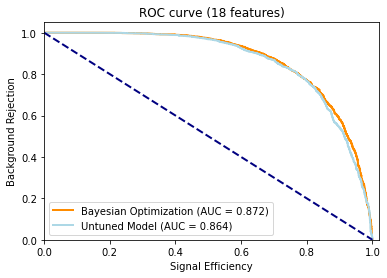

In [29]:
# Plot ROC curve - Compare best_model with the untuned model
plt.plot(tpr_bo, 1-fpr_bo, color='darkorange',lw=2, label='Bayesian Optimization (AUC = %0.3f)' % roc_auc_bo)
plt.plot(tpr_un, 1-fpr_un, color='lightblue',lw=2, label='Untuned Model (AUC = %0.3f)' % roc_auc_un)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.05])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('ROC curve (18 features)')
plt.legend(loc="lower left");

Plot feature importance with [plot_importance](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.plot_importance):

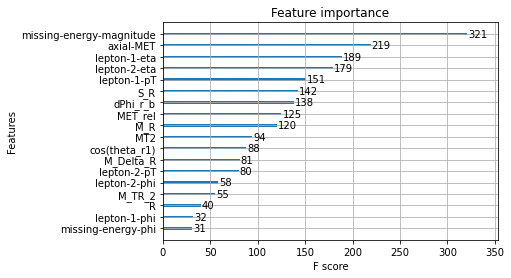

In [30]:
xgb.plot_importance(best_model);

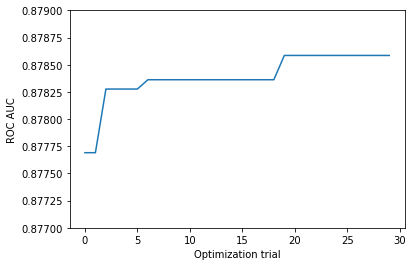

In [32]:
# Plot the best ROC AUC against the amount of optimization trials. Higher is better
data[['score']].cummax().plot(ylim=[0.877, 0.879 ], legend=None)
plt.xlabel('Optimization trial')
plt.ylabel('ROC AUC');

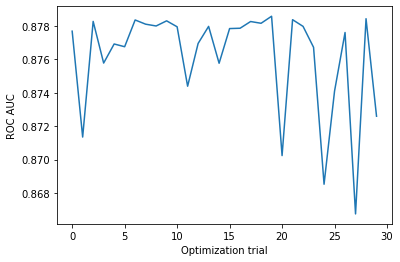

In [33]:
# Plot ROC AUC against optimization trials
data[['score']].plot(legend=None)
plt.xlabel('Optimization trial')
plt.ylabel('ROC AUC');

In [34]:
# save best_model to file
pickle.dump(best_model, open("best-model-18.pickle.dat", "wb"))

In [35]:
# dump model with feature map
best_model.dump_model('best-model-18.raw.txt')

### 7.1 High Features

In [36]:
# Make a dataset using only the 10 high-level features
X_train_high = X_train[high_features]
X_val_high = X_val[high_features]
X_test_high = X_test[high_features]

DM_train_high = xgb.DMatrix(X_train_high, label=y_train)
DM_val_high = xgb.DMatrix(X_val_high, label=y_val)
DM_test_high = xgb.DMatrix(X_test_high, label=y_test)

In [37]:
np.random.seed(22)

xgb_trainer_high = XGBTrainer(DM_train_high, DM_val_high)

parameters_high, values_high, experiment_high, model_high = optimize(
                                                                     minimize=False, 
                                                                     total_trials=search_trials,
                                                                     parameters=hyperparameter_space,
                                                                     evaluation_function=xgb_trainer.train_evaluate,
                                                                     objective_name='score',
                                                                    )

[INFO 08-19 18:34:35] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 08-19 18:34:35] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 08-19 18:34:35] ax.service.managed_loop: Running optimization trial 1...
[INFO 08-19 18:35:42] ax.service.managed_loop: Running optimization trial 2...
[INFO 08-19 18:36:38] ax.service.managed_loop: Running optimization trial 3...
[INFO 08-19 18:36:49] ax.service.managed_loop: Running optimization trial 4...
[INFO 08-19 18:36:54] ax.service.managed_loop: Running optimization trial 5...
[INFO 08-19 18:37:51] ax.service.managed_loop: Running optimization trial 6...
[INFO 08-19 18:38:11] ax.service.managed_loop: Running optimization trial 7...
[INFO 08-19 18:38:40] ax.service.managed_loop: Running optimization trial 8...
[INFO 08-19 

In [38]:
np.random.seed(0)

data_high = experiment_high.fetch_data().df.rename(columns={"mean": "score"})

# Pick out the parameters of the best iteration and train the training dataset with those parameters
best_arm_name_high = data_high.arm_name[data_high.score.idxmax()]
best_arm_high = experiment_high.arms_by_name[best_arm_name_high]
best_model_high = xgb_trainer_high.train_early_stop(best_arm_high.parameters)

# Calculate predictions for the test set using the best model
preds_bo_high = best_model_high.predict(DM_test_high)

# ROC AUC
fpr_bo_high, tpr_bo_high, _ = roc_curve(y_test, preds_bo_high)
roc_auc_bo_high = auc(fpr_bo_high, tpr_bo_high)
roc_auc_bo_high

0.8539491337242329

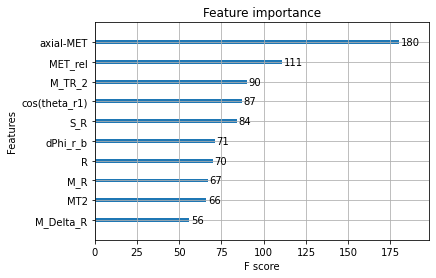

In [39]:
# Plot feature importance
xgb.plot_importance(best_model_high);

### 7.2 Low Features

In [40]:
# Make a dataset using only the 8 low-level features
X_train_low = X_train[low_features]
X_val_low = X_val[low_features]
X_test_low = X_test[low_features]

DM_train_low = xgb.DMatrix(X_train_low, label=y_train)
DM_val_low = xgb.DMatrix(X_val_low, label=y_val)
DM_test_low = xgb.DMatrix(X_test_low, label=y_test)

In [41]:
np.random.seed(22)

xgb_trainer_low = XGBTrainer(DM_train_low, DM_val_low)

parameters_low, values_low, experiment_low, model_low = optimize(
                                                                 minimize=False, 
                                                                 total_trials=search_trials,
                                                                 parameters=hyperparameter_space,
                                                                 evaluation_function=xgb_trainer.train_evaluate,
                                                                 objective_name='score'
                                                                 )

[INFO 08-19 18:53:59] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due to  model-fitting.
[INFO 08-19 18:53:59] ax.service.managed_loop: Started full optimization with 30 steps.
[INFO 08-19 18:53:59] ax.service.managed_loop: Running optimization trial 1...
[INFO 08-19 18:54:52] ax.service.managed_loop: Running optimization trial 2...
[INFO 08-19 18:54:53] ax.service.managed_loop: Running optimization trial 3...
[INFO 08-19 18:55:53] ax.service.managed_loop: Running optimization trial 4...
[INFO 08-19 18:55:56] ax.service.managed_loop: Running optimization trial 5...
[INFO 08-19 18:55:57] ax.service.managed_loop: Running optimization trial 6...
[INFO 08-19 18:57:11] ax.service.managed_loop: Running optimization trial 7...
[INFO 08-19 18:57:43] ax.service.managed_loop: Running optimization trial 8...
[INFO 08-19 

In [42]:
np.random.seed(0)

data_low = experiment_low.fetch_data().df.rename(columns={"mean": "score"})

# Pick out the parameters of the best iteration and train the training dataset with those parameters
best_arm_name_low = data_low.arm_name[data_low.score.idxmax()]
best_arm_low = experiment_low.arms_by_name[best_arm_name_low]
best_model_low = xgb_trainer_low.train_early_stop(best_arm_low.parameters)

# Calculate predictions for the test set using the best model
preds_bo_low = best_model_low.predict(DM_test_low)

# ROC AUC
fpr_bo_low, tpr_bo_low, _ = roc_curve(y_test, preds_bo_low)
roc_auc_bo_low = auc(fpr_bo_low, tpr_bo_low)
roc_auc_bo_low

0.8548630225072075

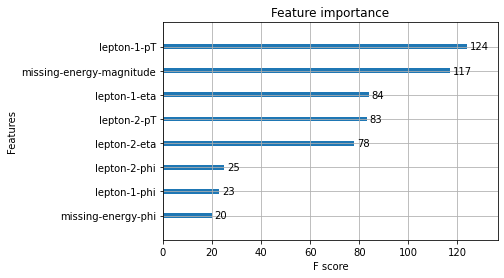

In [43]:
# Plot feature importance
xgb.plot_importance(best_model_low);

### 7.3 Final Results

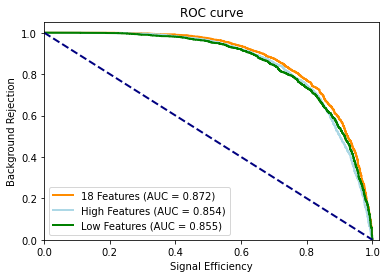

In [44]:
# Plotting ROC curve
plt.plot(tpr_bo, 1-fpr_bo, color='darkorange',lw=2, label='18 Features (AUC = %0.3f)' % roc_auc_bo)
plt.plot(tpr_bo_high, 1-fpr_bo_high, color='lightblue',lw=2, label='High Features (AUC = %0.3f)' % roc_auc_bo_high)
plt.plot(tpr_bo_low, 1-fpr_bo_low, color='green',lw=2, label='Low Features (AUC = %0.3f)' % roc_auc_bo_low)
plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.05])
plt.xlabel('Signal Efficiency')
plt.ylabel('Background Rejection')
plt.title('ROC curve')
plt.legend(loc="lower left");